In [1]:
#!pip install ultralytics
#!pip install easyocr

In [2]:
import sys
print(sys.version)

3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [3]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [6]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread("C:\\Users\\HLC\\Desktop\\biensoxe2.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

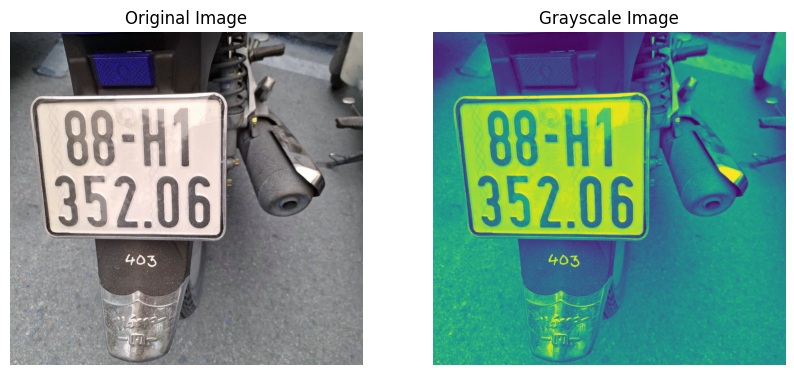

In [7]:
# B2 Hiển thị ảnh gốc và ảnh grayscale sử dụng matplotlib
plt.figure(figsize=(10, 5))
# Hiển thị ảnh gốc
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')  # Tắt trục tọa độ
# Hiển thị ảnh grayscale
plt.subplot(1, 2, 2)
plt.imshow(gray_image)
plt.title("Grayscale Image")
plt.axis('off')  # Tắt trục tọa độ
plt.show()

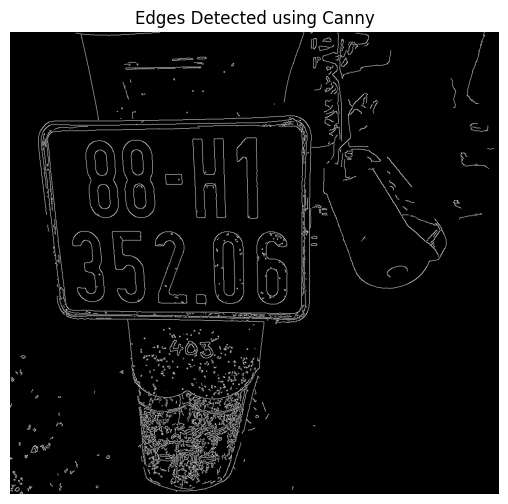

In [8]:
edges = cv2.Canny(gray_image, 100, 200)
# Hiển thị bức ảnh với matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(edges, cmap='gray')
plt.title('Edges Detected using Canny')
plt.axis('off')  # Tắt trục
plt.show()

In [9]:
# B4 Tiền xử lý và chuẩn bị các ký tự từ vùng biển số
def extract_characters_from_plate(license_plate_image):
    # Chuyển ảnh thành ảnh xám
    gray = cv2.cvtColor(license_plate_image, cv2.COLOR_BGR2GRAY)
    
    # Áp dụng threshold để phân tách nền và các ký tự
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Tìm các contours của các ký tự
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    character_images = []

    # Duyệt qua các contours và cắt các ký tự ra
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Lọc các contours có diện tích đủ lớn
            x, y, w, h = cv2.boundingRect(contour)
            character_image = thresholded[y:y+h, x:x+w]
            character_images.append(character_image)
    
    return character_images

In [10]:
#bo sung crop 
license_plate_region = image[190:370, 170:410]  # Ví dụ (thay tọa độ theo ảnh bạn)
license_plate_regions = [license_plate_region]

# B5 Kiểm tra kích thước của mỗi vùng biển số cắt ra
for i, region in enumerate(license_plate_regions):
    print(f"Vùng biển số {i+1}: {region.shape}")

Vùng biển số 1: (180, 240, 3)


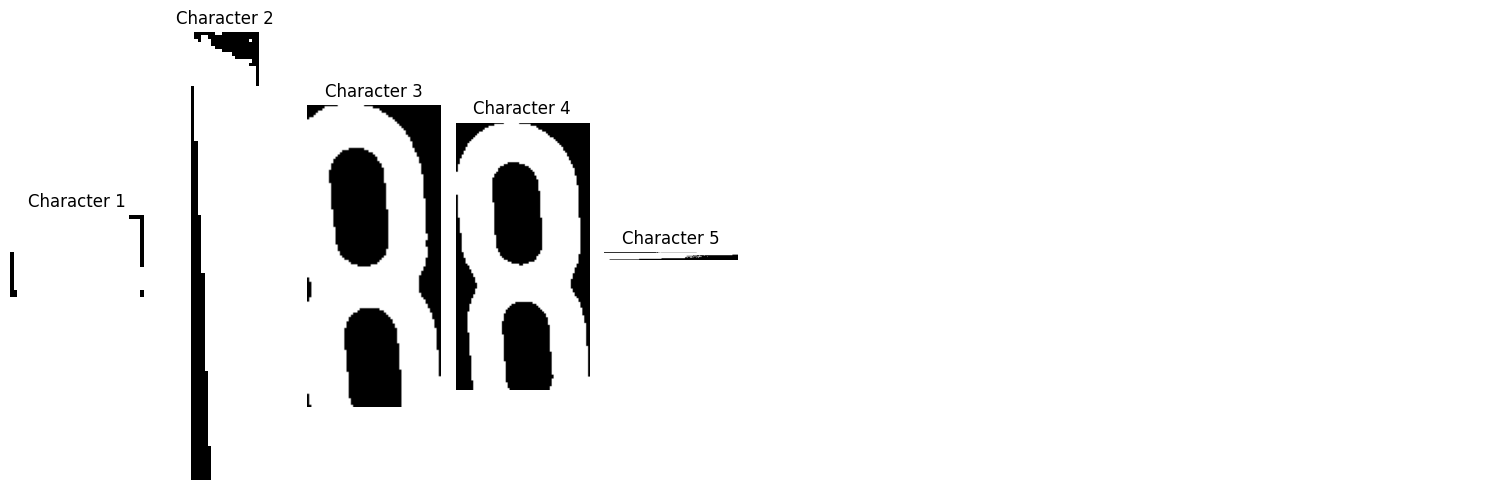

In [11]:
# B6 Tiến hành cắt các ký tự từ mỗi vùng biển số
all_character_images = []
for license_plate_image in license_plate_regions:
    characters = extract_characters_from_plate(license_plate_image)
    all_character_images.extend(characters)

# Hiển thị các ký tự đã cắt ra (ví dụ: chỉ hiển thị 5 ký tự đầu tiên)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))

for i, ax in enumerate(axes):
    if i < len(all_character_images):
        ax.imshow(all_character_images[i], cmap='gray')
        ax.set_title(f"Character {i+1}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [12]:
#B7
import cv2
import os

# Đảm bảo rằng thư mục nơi bạn lưu các hình ảnh tồn tại
output_dir = 'saved_characters/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lưu các hình ảnh trong all_character_images
for i, char_image in enumerate(all_character_images):
    # Tạo tên file cho mỗi hình ảnh (ví dụ: "char_0.png", "char_1.png", ...)
    file_name = os.path.join(output_dir, f'char_{i}.png')
    
    # Lưu hình ảnh bằng cv2
    cv2.imwrite(file_name, char_image)

    print(f"Đã lưu hình ảnh: {file_name}")


Đã lưu hình ảnh: saved_characters/char_0.png
Đã lưu hình ảnh: saved_characters/char_1.png
Đã lưu hình ảnh: saved_characters/char_2.png
Đã lưu hình ảnh: saved_characters/char_3.png
Đã lưu hình ảnh: saved_characters/char_4.png


In [13]:
#B8 Tạo tự động 2 thư mục train và validation trong dataset
from PIL import Image, ImageDraw, ImageFont
import os

# Đường dẫn đến thư mục dữ liệu
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Các ký tự từ 0-9 và a-z
characters = [str(i) for i in range(10)] + [chr(i) for i in range(97, 123)]

# Tạo các thư mục cho train và validation
for dir_path in [train_dir, val_dir]:
    for char in characters:
        os.makedirs(os.path.join(dir_path, char), exist_ok=True)

# Hàm tạo hình ảnh đơn giản cho số hoặc chữ
def create_image_with_text(text, size=(64, 64)):
    # Tạo ảnh trắng
    image = Image.new('RGB', size, (255, 255, 255))
    draw = ImageDraw.Draw(image)

    # Chọn phông chữ (có thể thay phông chữ hoặc kích thước nếu cần)
    font = ImageFont.load_default()

    # Tính toán kích thước của văn bản với textbbox
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

    # Tính toán vị trí để chữ ở giữa
    position = ((size[0] - text_width) // 2, (size[1] - text_height) // 2)

    # Vẽ chữ vào ảnh
    draw.text(position, text, (0, 0, 0), font=font)

    return image

# Tạo các hình ảnh cho train và validation
for char in characters:
    for i in range(100):  # Giả sử bạn muốn tạo 100 hình ảnh cho mỗi ký tự
        # Tạo hình ảnh cho train
        train_image = create_image_with_text(char)
        train_image.save(os.path.join(train_dir, char, f'{char}_{i}.png'))

        # Tạo hình ảnh cho validation (có thể tạo ít hình ảnh hơn)
        if i < 20:  # Tạo 20 hình ảnh cho mỗi ký tự trong thư mục validation
            val_image = create_image_with_text(char)
            val_image.save(os.path.join(val_dir, char, f'{char}_{i}.png'))

print("Đã tạo thư mục và hình ảnh cho train và validation.")

Đã tạo thư mục và hình ảnh cho train và validation.


In [14]:
#B9
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Đường dẫn tới thư mục chứa dữ liệu
train_dir = 'dataset/train'  # Thư mục chứa dữ liệu huấn luyện
val_dir = 'dataset/validation'  # Thư mục chứa dữ liệu xác thực

# Khởi tạo ImageDataGenerator để tiền xử lý và làm augmentation cho dữ liệu
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Chuẩn hóa hình ảnh
    rotation_range=20,  # Quay ảnh ngẫu nhiên
    width_shift_range=0.2,  # Dịch chuyển ảnh ngang
    height_shift_range=0.2,  # Dịch chuyển ảnh dọc
    shear_range=0.2,  # Biến dạng ảnh
    zoom_range=0.2,  # Phóng to ảnh
    horizontal_flip=True,  # Lật ảnh ngang
    fill_mode='nearest'  # Phương pháp điền vùng trống
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Chỉ chuẩn hóa ảnh cho validation

# Tạo các bộ dữ liệu từ các thư mục
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  # Đặt kích thước ảnh đầu vào (có thể điều chỉnh)
    batch_size=32,
    class_mode='sparse'  # Dùng sparse cho các nhãn dạng số nguyên (0, 1, 2, ...)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='sparse'
)

# Xây dựng mô hình CNN (hoặc mô hình của bạn)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(37, activation='softmax')  # Số lớp đầu ra tương ứng với các nhãn (0-9)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Found 3600 images belonging to 36 classes.
Found 720 images belonging to 36 classes.


C:\Users\HLC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\HLC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.0256 - loss: 3.6401 - val_accuracy: 0.0270 - val_loss: 3.5995
Epoch 2/10
  1/112 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.0312 - loss: 3.6127

C:\Users\HLC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0312 - loss: 3.6127 - val_accuracy: 0.0284 - val_loss: 3.6005
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.0281 - loss: 3.6022 - val_accuracy: 0.0256 - val_loss: 3.5945
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 3.5630 - val_accuracy: 0.0284 - val_loss: 3.5947
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.0264 - loss: 3.5916 - val_accuracy: 0.0284 - val_loss: 3.5857
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0312 - loss: 3.5820 - val_accuracy: 0.0270 - val_loss: 3.5875
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.0225 - loss: 3.5868 - val_accuracy: 0.0284 - val_loss: 3.5506
Epoch 8/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0000e+00 - loss: 3.5461 - val_accuracy: 0.0284 - val_loss: 3.5151
Epoch 9/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.0537 - loss: 3.4225 - val_acc

In [15]:
import cv2
import matplotlib.pyplot as plt
import easyocr

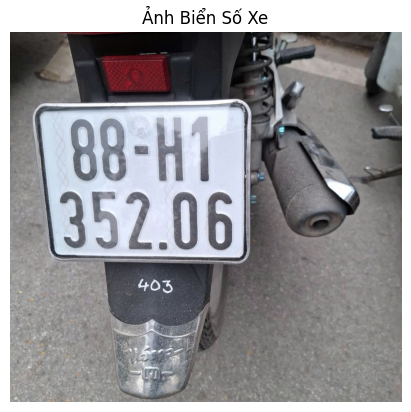

In [16]:
image_path = "C:\\Users\\HLC\\Desktop\\biensoxe2.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title('Ảnh Biển Số Xe')
plt.axis('off')
plt.show()

In [17]:
reader = easyocr.Reader(['en', 'vi'])  # Hỗ trợ cả tiếng Việt và tiếng Anh
results = reader.readtext(image_path)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [18]:
print("📌 Kết quả nhận diện biển số xe:")
for (bbox, text, confidence) in results:
    print(f"🚘 Biển số: {text} | 🎯 Độ chính xác: {confidence * 100:.2f}%")

📌 Kết quả nhận diện biển số xe:
🚘 Biển số: 88-H1 | 🎯 Độ chính xác: 89.47%
🚘 Biển số: 352.06 | 🎯 Độ chính xác: 88.74%
🚘 Biển số: 403 | 🎯 Độ chính xác: 99.96%


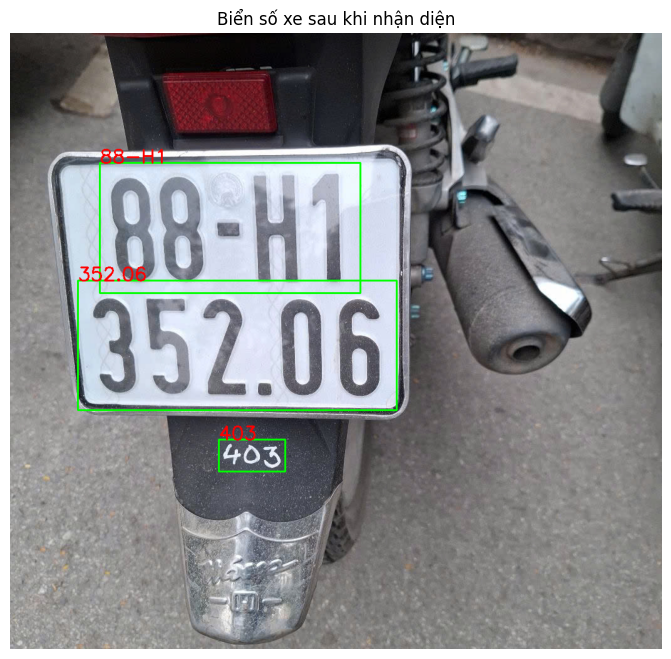

In [19]:
for (bbox, text, confidence) in results:
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))
    
    cv2.rectangle(image_rgb, top_left, bottom_right, (0, 255, 0), 2)
    cv2.putText(image_rgb, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.title('Biển số xe sau khi nhận diện')
plt.show()